# Lab 8- Trees, Forests, and Classification
- **Author:** Suraj R. Nair, based on previous material from Emily Aiken.
- **Date:** March 13, 2024
- **Course:** INFO 251: Applied machine learning

## Topics:
1. Decision Trees
2. Random Forests
3. Classification performance metrics

## Learning Goals:
At the end of this lab, you will...
- Understand the recursive algorithm to grow a decision tree
- Know the standard splitting criteria used for decision trees
- Understand how feature importances are calculated for decision trees
- Know the main hyperparameters for decision trees and random forests, and how to tune them to prevent overfitting
- Know the main performance measures for classification: accuracy, TPR, FPR, precision, and recall
- Understand ROC curves, precision and recall plots, and methods for determining the "optimal" classification threshold

## Resources:
- [Feature importances in random forests](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, r2_score

### I. Decision Tree

In [19]:
# Data
np.random.seed(11)
data = datasets.load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target
for col in df.columns:
    if col != 'target':
        df[col] = df[col] + np.random.normal(0, 4*df[col].std(), len(df))
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,42.650656,12.142825,18.542687,107.203998,0.101526,0.474664,0.134440,0.052910,0.245081,0.105570,...,-29.880505,182.358780,3842.645388,0.092734,0.835078,1.930021,0.390260,0.826879,0.218944,0
1,16.537459,31.851392,98.334421,2620.597818,-0.002968,0.004821,-0.083235,-0.132924,0.237900,0.060759,...,-7.657294,167.595033,4007.461269,0.139624,-0.101997,-2.229807,0.352541,0.282807,0.060947,0
2,12.859475,59.881025,45.019332,2949.191607,0.099142,0.102664,0.302345,0.421009,0.074963,0.111299,...,25.998127,311.174184,4563.628253,0.138345,0.652987,-0.109673,0.497201,0.616588,0.107790,0
3,-25.981697,0.083060,165.210941,868.160491,0.114414,0.439352,-0.430281,-0.062867,0.298906,0.077736,...,10.942561,127.678122,-218.976759,0.133604,0.058706,-1.787583,0.027961,0.795497,0.110845,0
4,20.173218,-13.076572,117.215692,1617.261239,0.039511,0.030661,0.159703,0.148632,0.371873,0.063593,...,24.177500,236.759445,683.587464,0.309009,-0.169822,0.618000,0.064061,0.159589,0.259095,0


In [20]:
df.target.value_counts()

1    357
0    212
Name: target, dtype: int64

In [16]:
print('Observations in class 0: %i' % len(df[df['target'] == 0]))
print('Observations in class 1: %i' % len(df[df['target'] == 1]))

Observations in class 0: 212
Observations in class 1: 357


In [21]:
# Split data into training and test
train, test = train_test_split(df, shuffle=True, test_size=0.25, random_state=0)
x_train, y_train = train.drop('target', axis=1), train['target']
x_test, y_test = test.drop('target', axis=1), test['target']

In [22]:
# Fit model without tuning hyperparameters
model = DecisionTreeClassifier(max_depth=2)
model.fit(x_train, y_train)
yhat_train = model.predict(x_train)
yhat_test = model.predict(x_test)

print('Accuracy (train): %.2f' % accuracy_score(y_train, yhat_train))
print('Accuracy (test): %.2f' % accuracy_score(y_test, yhat_test))

print('Precision (train): %.2f' % recall_score(y_train, yhat_train))
print('Precision (test): %.2f' % recall_score(y_test, yhat_test))

print('Recall (train): %.2f' % precision_score(y_train, yhat_train))
print('Recall (test): %.2f' % precision_score(y_test, yhat_test))

Accuracy (train): 0.67
Accuracy (test): 0.57
Precision (train): 0.65
Precision (test): 0.64
Recall (train): 0.78
Recall (test): 0.67


#### A. Hyperparameter Tuning

In [23]:
# Tune hyperparameter: max_depth
cv = KFold(n_splits=3, shuffle=True, random_state=1)
params = {'max_depth':[2, 4, 6, 8, 10, 12, 14]}
cv_model = GridSearchCV(model, param_grid=params, scoring='accuracy', refit=True, return_train_score=True, cv=cv)
cv_model.fit(x_train, y_train)
cv_results = pd.DataFrame(cv_model.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.012939,0.005325,0.001547,0.002188,2,{'max_depth': 2},0.591549,0.542254,0.676056,0.603286,0.055252,7,0.721831,0.672535,0.704225,0.699531,0.020397
1,0.011972,0.006451,0.000665,0.000941,4,{'max_depth': 4},0.640845,0.626761,0.661972,0.643192,0.014470,2,0.852113,0.834507,0.816901,0.834507,0.014375
2,0.015942,0.000370,0.000000,0.000000,6,{'max_depth': 6},0.661972,0.612676,0.633803,0.636150,0.020193,4,0.954225,0.933099,0.943662,0.943662,0.008625
3,0.015592,0.000051,0.005240,0.007411,8,{'max_depth': 8},0.654930,0.612676,0.640845,0.636150,0.017566,3,0.982394,0.992958,1.000000,0.991784,0.007235
4,0.020493,0.007551,0.005210,0.007367,10,{'max_depth': 10},0.647887,0.626761,0.626761,0.633803,0.009959,5,0.996479,1.000000,1.000000,0.998826,0.001660


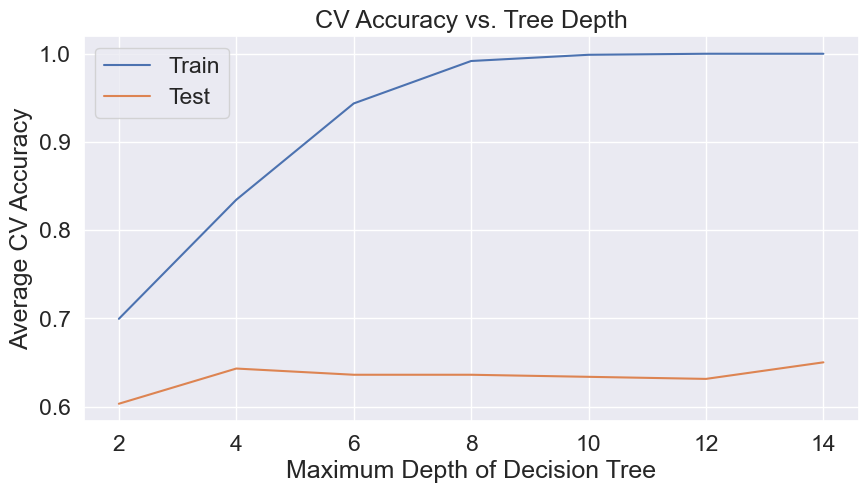

In [24]:
# Plot CV accuracy as a function of maximum depth
sns.set(font_scale=1.5)
fig, ax = plt.subplots(1, figsize=(10, 5))
ax.plot(cv_results['param_max_depth'], cv_results['mean_train_score'], label='Train')
ax.plot(cv_results['param_max_depth'], cv_results['mean_test_score'], label='Test')
ax.set_xlabel('Maximum Depth of Decision Tree')
ax.set_ylabel('Average CV Accuracy')
ax.set_title('CV Accuracy vs. Tree Depth')
ax.legend(loc='best')
plt.show()

In [25]:
# Get predictions on test set using best model
model = cv_model.best_estimator_
model.fit(x_train, y_train)
yhat_train = model.predict(x_train)
yhat_test = model.predict(x_test)

print('Best maximum depth: %i' % cv_model.best_params_['max_depth'])

print('Accuracy (train): %.2f' % accuracy_score(y_train, yhat_train))
print('Accuracy (test): %.2f' % accuracy_score(y_test, yhat_test))

print('Precision (train): %.2f' % recall_score(y_train, yhat_train))
print('Precision (test): %.2f' % recall_score(y_test, yhat_test))

print('Recall (train): %.2f' % precision_score(y_train, yhat_train))
print('Recall (test): %.2f' % precision_score(y_test, yhat_test))

Best maximum depth: 14
Accuracy (train): 1.00
Accuracy (test): 0.55
Precision (train): 1.00
Precision (test): 0.67
Recall (train): 1.00
Recall (test): 0.63


#### B. Feature Importances

In [26]:
importances = model.feature_importances_
importances = pd.DataFrame([x_train.columns, importances]).T
importances.columns = ['Feature', 'Importance']
importances = importances.sort_values('Importance', ascending=False)[:10]

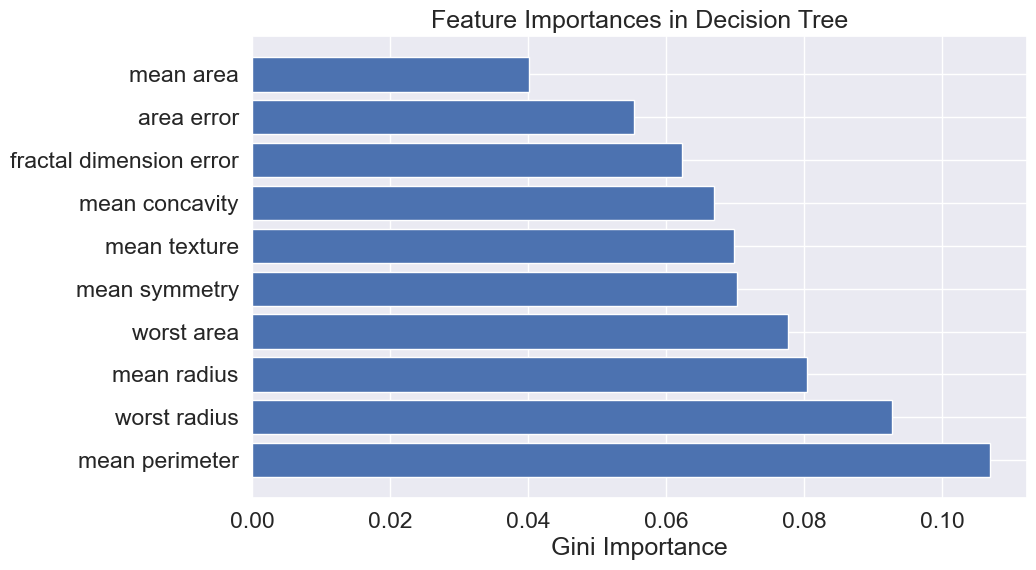

In [27]:
# Bar chart
fig, ax = plt.subplots(1, figsize=(10, 6))
plt.barh(importances['Feature'], importances['Importance'])
ax.set_xlabel('Gini Importance')
ax.set_title('Feature Importances in Decision Tree')
plt.show()

### II. Random Forest

In [28]:
# Fit model without tuning hyperparameters
model = RandomForestClassifier(n_estimators=100, random_state=1)
model.fit(x_train, y_train)
yhat_train = model.predict(x_train)
yhat_test = model.predict(x_test)

print('Accuracy (train): %.2f' % accuracy_score(y_train, yhat_train))
print('Accuracy (test): %.2f' % accuracy_score(y_test, yhat_test))

print('Precision (train): %.2f' % recall_score(y_train, yhat_train))
print('Precision (test): %.2f' % recall_score(y_test, yhat_test))

print('Recall (train): %.2f' % precision_score(y_train, yhat_train))
print('Recall (test): %.2f' % precision_score(y_test, yhat_test))

Accuracy (train): 1.00
Accuracy (test): 0.73
Precision (train): 1.00
Precision (test): 0.93
Recall (train): 1.00
Recall (test): 0.72


#### A. Hyperparameter Tuning

In [29]:
# Tune hyperparameters: max_depth, n_estimators
model = RandomForestClassifier(random_state=1)
cv = KFold(n_splits=3, shuffle=True, random_state=1)
params = {'max_depth':[2, 4, 6, 8], 'n_estimators':[25, 50, 100]}
cv_model = GridSearchCV(model, param_grid=params, scoring='accuracy', refit=True, return_train_score=True, cv=cv)
cv_model.fit(x_train, y_train)
model = cv_model.best_estimator_
model.fit(x_train, y_train)
yhat_train = model.predict(x_train)
yhat_test = model.predict(x_test)

print('Best maximum depth: %i' % cv_model.best_params_['max_depth'])
print('Best number of estimators: %i' % cv_model.best_params_['n_estimators'])

print('Accuracy (train): %.2f' % accuracy_score(y_train, yhat_train))
print('Accuracy (test): %.2f' % accuracy_score(y_test, yhat_test))

print('Precision (train): %.2f' % recall_score(y_train, yhat_train))
print('Precision (test): %.2f' % recall_score(y_test, yhat_test))

print('Recall (train): %.2f' % precision_score(y_train, yhat_train))
print('Recall (test): %.2f' % precision_score(y_test, yhat_test))

Best maximum depth: 6
Best number of estimators: 100
Accuracy (train): 0.98
Accuracy (test): 0.69
Precision (train): 1.00
Precision (test): 0.93
Recall (train): 0.97
Recall (test): 0.69


#### B. ROC Curves

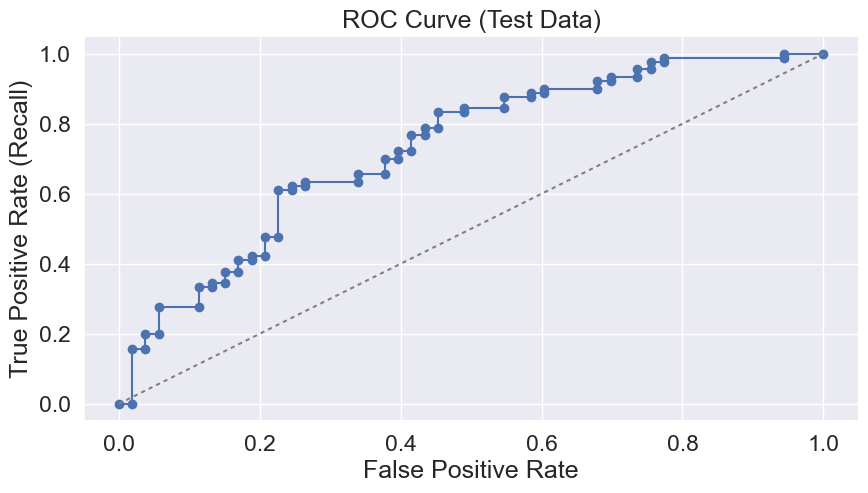

In [30]:
# ROC Curve
yhat_test_proba = model.predict_proba(x_test)[:, 1]
fprs, tprs, thresholds = roc_curve(y_test, yhat_test_proba)

fig, ax = plt.subplots(1, figsize=(10, 5))
ax.scatter(fprs, tprs)
ax.plot(fprs, tprs)
ax.plot([0, 1], [0, 1], color='grey', dashes=[2, 2])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate (Recall)')
ax.set_title('ROC Curve (Test Data)')
plt.show()

In [31]:
# Get area under the curve
print('AUC score: %.2f' % roc_auc_score(y_test, yhat_test_proba))

AUC score: 0.73


In [32]:
# Get "optimal" threshold: the one closest to the top-left corner of the ROC graph
distances_from_top_left = [np.sqrt(tprs[i]**2 + (1-fprs[i])**2) for i in range(len(tprs))]
best_cutoff = np.argmin(distances_from_top_left)
print('Threshold closest to top-left corner of graph: %.2f (%.2f TPR, %.2f FPR)' % 
      (thresholds[best_cutoff], tprs[best_cutoff], fprs[best_cutoff]))

Threshold closest to top-left corner of graph: 0.70 (0.42 TPR, 0.21 FPR)


#### C. Precision and Recall Curves

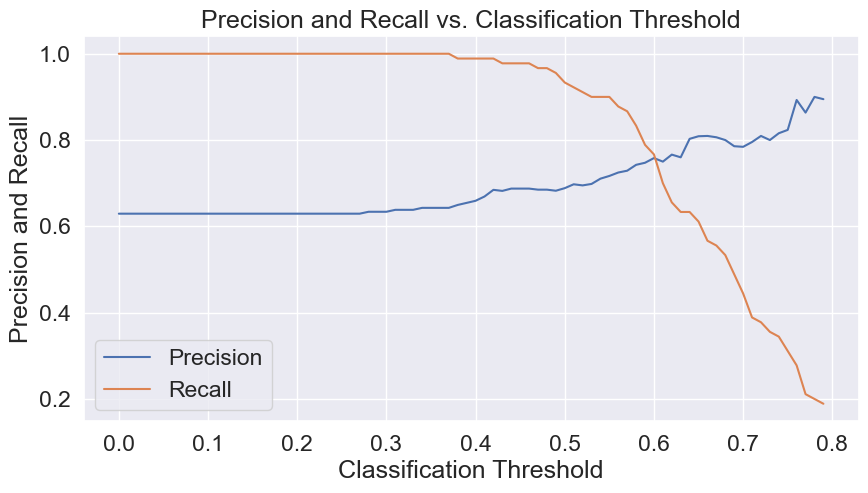

In [33]:
# Precision vs. recall plot
thresholds = np.arange(0, 0.80, .01)
precisions = [precision_score(y_test, (yhat_test_proba > t)) for t in thresholds]
recalls = [recall_score(y_test, (yhat_test_proba > t)) for t in thresholds]

fig, ax = plt.subplots(1, figsize=(10, 5))
ax.plot(thresholds, precisions, label='Precision')
ax.plot(thresholds, recalls, label='Recall')
ax.set_xlabel('Classification Threshold')
ax.set_ylabel('Precision and Recall')
ax.set_title('Precision and Recall vs. Classification Threshold')
ax.legend(loc='best')
plt.show()

In [34]:
# Get "optimal threshold": The one where precision and recall are balanced
best_threshold = np.argmin(np.abs(np.array(precisions) - np.array(recalls)))
print('Best threshold: %.2f (%.2f precision, %.2f recall)' % 
      (thresholds[best_threshold], precisions[best_threshold], recalls[best_threshold]))

Best threshold: 0.60 (0.76 precision, 0.77 recall)


#### D. Feature Importances

In [35]:
# Get feature importances
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
importances = pd.DataFrame([x_train.columns, importances]).T
importances.columns = ['Feature', 'Importance']
importances = importances.sort_values('Importance', ascending=True)

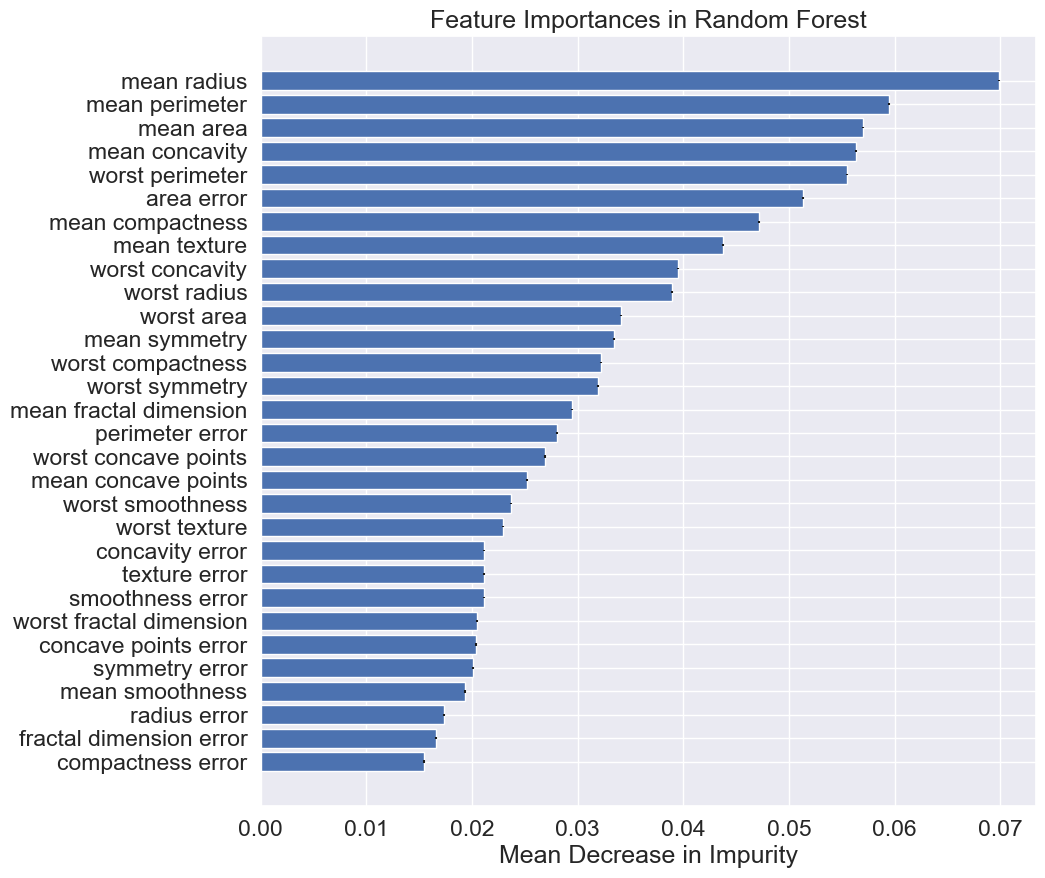

In [36]:
# Bar chart
fig, ax = plt.subplots(1, figsize=(10, 10))
plt.barh(importances['Feature'], importances['Importance'], yerr=std)
ax.set_xlabel('Mean Decrease in Impurity')
ax.set_title('Feature Importances in Random Forest')
plt.show()

### III. Over to you!
Let's revisit an old friend -- the [California Housing Dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html#sklearn.datasets.fetch_california_housing):
- The goal is to predict median housing value, using the available features. 
- Note that this is now a regression task
- Train a decision tree, try tuning *maximum depth* and report best r2
- Train a random forest, try tuning *maximum depth*, *n_estimators* and report best r2
- Calculate the feature importances for the best random forest, show mean and standard deviation in impurity decrease

You should be able to achieve an r2 score of above 0.70 on the test set using your well-tuned random forest.

In [58]:
data = datasets.fetch_california_housing()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

In [59]:
train, test = train_test_split(df, shuffle=True, test_size=0.25, random_state=0)
x_train, y_train = train.drop('target', axis=1), train['target']
x_test, y_test = test.drop('target', axis=1), test['target']

In [3]:
# Untuned decision tree


In [2]:
# Tuned decision tree


In [1]:
# Random Forest


In [4]:
# Plot Feature Importances
